<a href="https://colab.research.google.com/github/kursatkara/MAE_5020_Spring_2025/blob/master/06_05_in_class_exercise_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Description: Learning a Time-Varying Signal with a Neural Network

Train a feedforward neural network (FFNN) to learn a time-dependent function of the form:

$$
y(t) = A_0 \cdot e^{-a t} \cdot \sin(\omega_0 t - b t)
$$

Where:

- $A_0 = 1.0$ is the initial amplitude  
- $a = 0.5$ controls the exponential decay rate  
- $b = 1.0$ is a linear phase shift rate  
- $f = 5.0$ Hz is the frequency  
- $\omega_0 = 2\pi f$ is the angular frequency  
- $t \in [0, 1]$ seconds is the time variable  

The function exhibits both **amplitude modulation** (via the decaying exponential $e^{-a t}$) and **phase modulation** (via the $-b t$ term inside the sine function).

We generate 3600 samples of $t$ uniformly spaced in the interval $[0, 1]$, and normalize them to center around 0. Then we train an FFNN to learn the mapping from $t \mapsto y(t)$ using:

- Two hidden layers of size 128  
- Activation: `tanh`  
- Loss function: Mean Squared Error (MSE)  
- Optimizer: Adam, with learning rate $\eta = 5 \times 10^{-4}$  
- Train/validation split: 80% / 20%  
- Number of training epochs: 4000  

The goal is to minimize the difference between the predicted signal and the true signal across the entire domain.


## Visualize the function $y(t)$

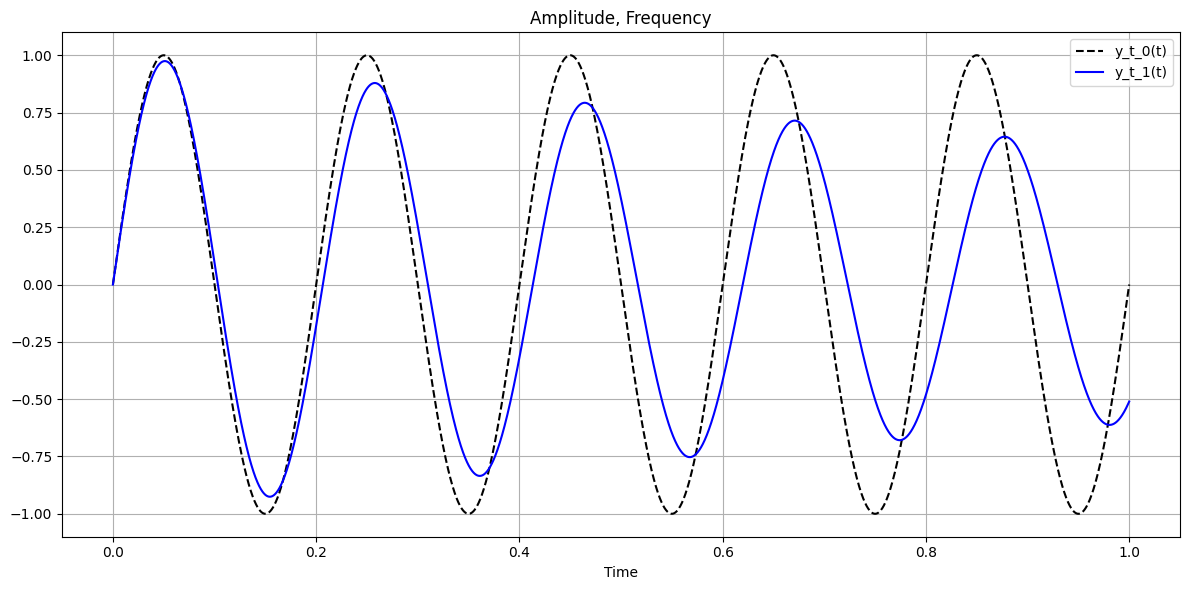

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Time range
t = np.linspace(0, 1, 3600)

# Parameters
A0 = 1.0         # initial amplitude
f = 5.0          # initial frequency (1 Hz)
omega0 = 2 * np.pi * f

y_t_0 = A0 * np.sin(omega0 * t)
y_t_1 = A0 * np.exp(-0.5 * t) * np.sin(omega0 * t - 1.0 * t)


# Plot results
plt.figure(figsize=(12, 6))

plt.plot(t, y_t_0, label='y_t_0(t)', color='black', linestyle='--')
plt.plot(t, y_t_1, label='y_t_1(t)', color='blue')
plt.legend(); plt.grid(True)
plt.title("Amplitude, Frequency")
plt.xlabel("Time")
plt.tight_layout()
plt.show()


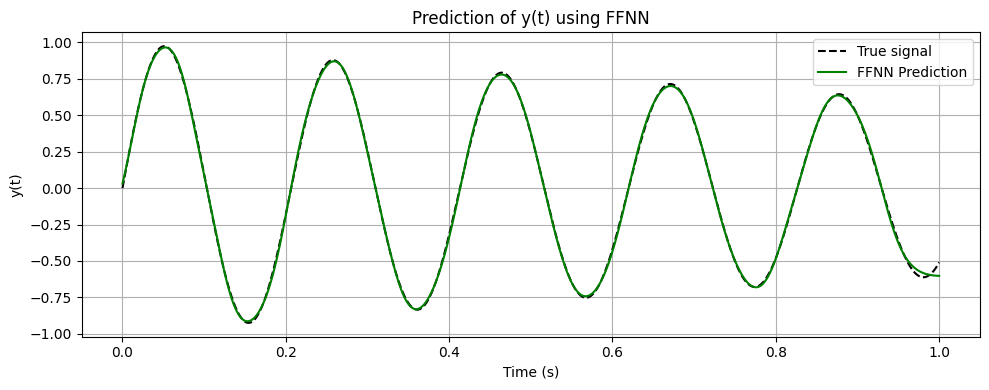

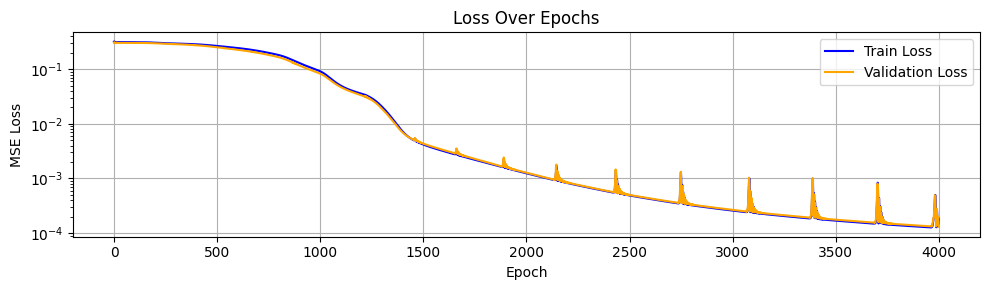

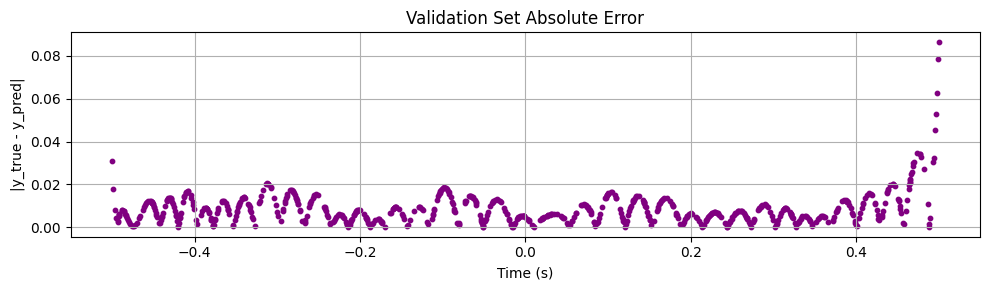

In [ ]:
# Imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set random seed
torch.manual_seed(42)

# Generate time data: 3600 samples over 1 second
t_full = torch.unsqueeze(torch.linspace(0, 1, 3600), dim=1)

# Parameters
A0 = 1.0         # initial amplitude
f = 5.0          # initial frequency (1 Hz)
omega0 = 2 * torch.pi * f

# True output: y(t) = sin(2π f t)
#y_full = A0 * torch.exp(0.0 * t_full) * torch.sin(omega0 * t_full - 0.0 * t_full)
y_full = A0 * torch.exp(-0.5 * t_full) * torch.sin(omega0 * t_full - 1.0 * t_full)

# Normalize input (optional but useful)
t_norm = t_full - 0.5  # center around 0

# Split into train and validation
t_train_np, t_val_np, y_train_np, y_val_np = train_test_split(
    t_norm.numpy(), y_full.numpy(), test_size=0.2, random_state=42)

t_train = torch.tensor(t_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)
t_val = torch.tensor(t_val_np, dtype=torch.float32)
y_val = torch.tensor(y_val_np, dtype=torch.float32)

# Define FFNN model
model = nn.Sequential(
    nn.Linear(1, 128),
    nn.Tanh(),
    nn.Linear(128, 128),
    nn.Tanh(),
    nn.Linear(128, 1)
)

# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.MSELoss()

# Training loop
epochs = 4000
train_loss = []
val_loss = []

for epoch in range(epochs):
    model.train()
    pred_train = model(t_train)
    loss = loss_fn(pred_train, y_train)
    train_loss.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        pred_val = model(t_val)
        val_loss.append(loss_fn(pred_val, y_val).item())

# Prediction on full time range
t_full_norm = t_full - 0.5
with torch.no_grad():
    pred_full = model(t_full_norm)

# Plot predictions
plt.figure(figsize=(10, 4))
plt.plot(t_full.numpy(), y_full.numpy(), label='True signal', linestyle='--', color='black')
plt.plot(t_full.numpy(), pred_full.numpy(), label='FFNN Prediction', color='green')
plt.title("Prediction of y(t) using FFNN")
plt.xlabel("Time (s)")
plt.ylabel("y(t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot training/validation loss
plt.figure(figsize=(10, 3))
plt.semilogy(train_loss, label="Train Loss", color="blue")
plt.semilogy(val_loss, label="Validation Loss", color="orange")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot absolute error on validation set
val_abs_error = torch.abs(y_val - pred_val)

plt.figure(figsize=(10, 3))
plt.scatter(t_val.numpy(), val_abs_error.numpy(), color="purple", s=10)
plt.title("Validation Set Absolute Error")
plt.xlabel("Time (s)")
plt.ylabel("|y_true - y_pred|")
plt.grid(True)
plt.tight_layout()
plt.show()


Model saved to /content/ffnn_damped_sine.pth


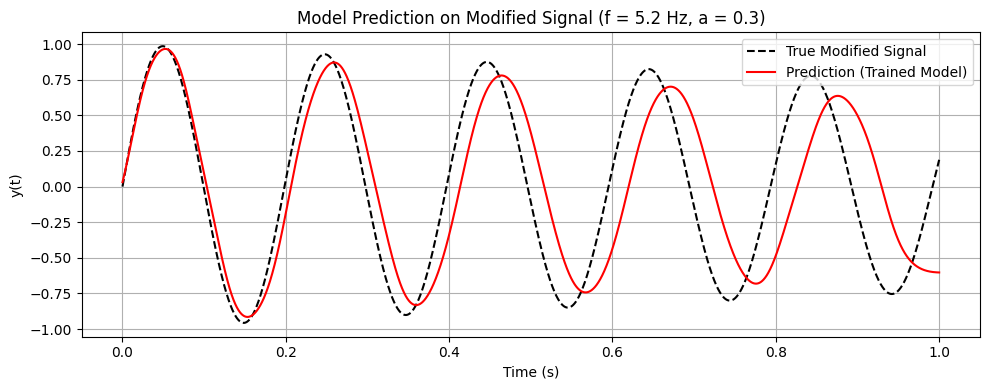

In [ ]:
# Imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set seed
torch.manual_seed(42)

# Original parameters
A0 = 1.0
f_train = 5.0
omega0_train = 2 * torch.pi * f_train
a_train = 0.5
b_train = 1.0

# Time vector
t_full = torch.unsqueeze(torch.linspace(0, 1, 3600), dim=1)
y_full = A0 * torch.exp(-a_train * t_full) * torch.sin(omega0_train * t_full - b_train * t_full)

# Normalize t
t_norm = t_full - 0.5

# Train/val split
t_train_np, t_val_np, y_train_np, y_val_np = train_test_split(
    t_norm.numpy(), y_full.numpy(), test_size=0.2, random_state=42)
t_train = torch.tensor(t_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)
t_val = torch.tensor(t_val_np, dtype=torch.float32)
y_val = torch.tensor(y_val_np, dtype=torch.float32)

# Define model
model = nn.Sequential(
    nn.Linear(1, 128),
    nn.Tanh(),
    nn.Linear(128, 128),
    nn.Tanh(),
    nn.Linear(128, 1)
)

# Train
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.MSELoss()
epochs = 4000

for epoch in range(epochs):
    model.train()
    pred = model(t_train)
    loss = loss_fn(pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# ✅ Save model
torch.save(model.state_dict(), "/content/ffnn_damped_sine.pth")
print("Model saved to /content/ffnn_damped_sine.pth")

# --------------------------------------------------------
# ✅ Load model and test with different parameters
# --------------------------------------------------------

# Slightly different parameters
f_test = 5.2      # slightly higher frequency
a_test = 0.3      # less decay
omega0_test = 2 * torch.pi * f_test

# Create new test signal
y_test = A0 * torch.exp(-a_test * t_full) * torch.sin(omega0_test * t_full - b_train * t_full)

# Normalize input again
t_test_norm = t_full - 0.5

# Load the model
model_loaded = nn.Sequential(
    nn.Linear(1, 128),
    nn.Tanh(),
    nn.Linear(128, 128),
    nn.Tanh(),
    nn.Linear(128, 1)
)
model_loaded.load_state_dict(torch.load("/content/ffnn_damped_sine.pth"))
model_loaded.eval()

# Predict new signal
with torch.no_grad():
    pred_test = model_loaded(t_test_norm)

# Plot true vs predicted signal
plt.figure(figsize=(10, 4))
plt.plot(t_full.numpy(), y_test.numpy(), label="True Modified Signal", linestyle="--", color="black")
plt.plot(t_full.numpy(), pred_test.numpy(), label="Prediction (Trained Model)", color="red")
plt.title("Model Prediction on Modified Signal (f = 5.2 Hz, a = 0.3)")
plt.xlabel("Time (s)")
plt.ylabel("y(t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Model saved to /content/ffnn_damped_sine.pth


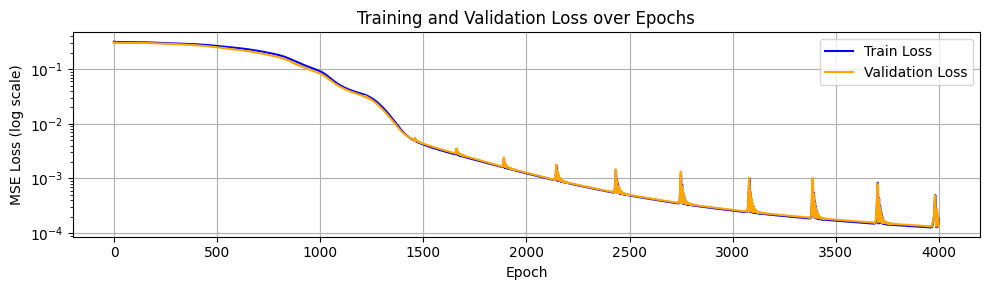

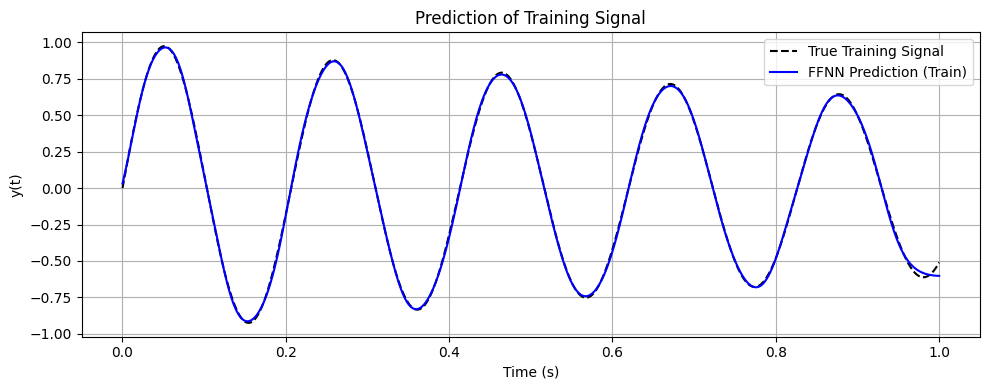

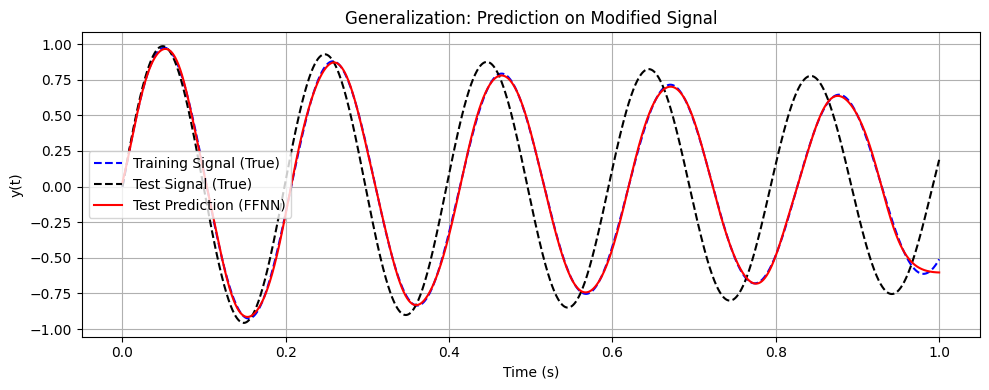

In [ ]:
# Imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set seed
torch.manual_seed(42)

# Original parameters (training)
A0 = 1.0
f_train = 5.0
omega0_train = 2 * torch.pi * f_train
a_train = 0.5
b_train = 1.0

# Generate training signal
t_full = torch.unsqueeze(torch.linspace(0, 1, 3600), dim=1)
y_full = A0 * torch.exp(-a_train * t_full) * torch.sin(omega0_train * t_full - b_train * t_full)

# Normalize t
t_norm = t_full - 0.5

# Split data
t_train_np, t_val_np, y_train_np, y_val_np = train_test_split(
    t_norm.numpy(), y_full.numpy(), test_size=0.2, random_state=42)
t_train = torch.tensor(t_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)
t_val = torch.tensor(t_val_np, dtype=torch.float32)
y_val = torch.tensor(y_val_np, dtype=torch.float32)

# Define FFNN model
model = nn.Sequential(
    nn.Linear(1, 128),
    nn.Tanh(),
    nn.Linear(128, 128),
    nn.Tanh(),
    nn.Linear(128, 1)
)

# Optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.MSELoss()
epochs = 4000
train_loss = []
val_loss = []

# Training loop
for epoch in range(epochs):
    model.train()
    pred_train = model(t_train)
    loss = loss_fn(pred_train, y_train)
    train_loss.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        pred_val = model(t_val)
        val_loss.append(loss_fn(pred_val, y_val).item())

# ✅ Save model
torch.save(model.state_dict(), "/content/ffnn_damped_sine.pth")
print("Model saved to /content/ffnn_damped_sine.pth")

# 🔹 Plot training/validation loss
plt.figure(figsize=(10, 3))
plt.semilogy(train_loss, label="Train Loss", color="blue")
plt.semilogy(val_loss, label="Validation Loss", color="orange")
plt.title("Training and Validation Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss (log scale)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 🔹 Plot prediction on training signal
t_full_norm = t_full - 0.5
with torch.no_grad():
    pred_train_full = model(t_full_norm)

plt.figure(figsize=(10, 4))
plt.plot(t_full.numpy(), y_full.numpy(), label="True Training Signal", linestyle="--", color="black")
plt.plot(t_full.numpy(), pred_train_full.numpy(), label="FFNN Prediction (Train)", color="blue")
plt.title("Prediction of Training Signal")
plt.xlabel("Time (s)")
plt.ylabel("y(t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------------------------------------------
# 🔹 Test: Load model and apply to new signal
# --------------------------------------------------------

# Test parameters (slightly different)
f_test = 5.2
a_test = 0.3
omega0_test = 2 * torch.pi * f_test

# Create test signal
y_test = A0 * torch.exp(-a_test * t_full) * torch.sin(omega0_test * t_full - b_train * t_full)
t_test_norm = t_full - 0.5

# Load saved model
model_loaded = nn.Sequential(
    nn.Linear(1, 128),
    nn.Tanh(),
    nn.Linear(128, 128),
    nn.Tanh(),
    nn.Linear(128, 1)
)
model_loaded.load_state_dict(torch.load("/content/ffnn_damped_sine.pth"))
model_loaded.eval()

# Predict test signal
with torch.no_grad():
    pred_test = model_loaded(t_test_norm)

# 🔹 Plot: Training vs Test signal prediction
plt.figure(figsize=(10, 4))
plt.plot(t_full.numpy(), y_full.numpy(), label="Training Signal (True)", linestyle="--", color="blue")
plt.plot(t_full.numpy(), y_test.numpy(), label="Test Signal (True)", linestyle="--", color="black")
plt.plot(t_full.numpy(), pred_test.numpy(), label="Test Prediction (FFNN)", color="red")
plt.title("Generalization: Prediction on Modified Signal")
plt.xlabel("Time (s)")
plt.ylabel("y(t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


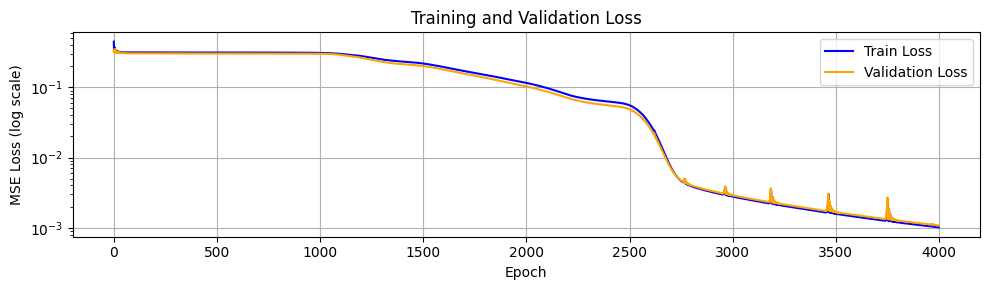

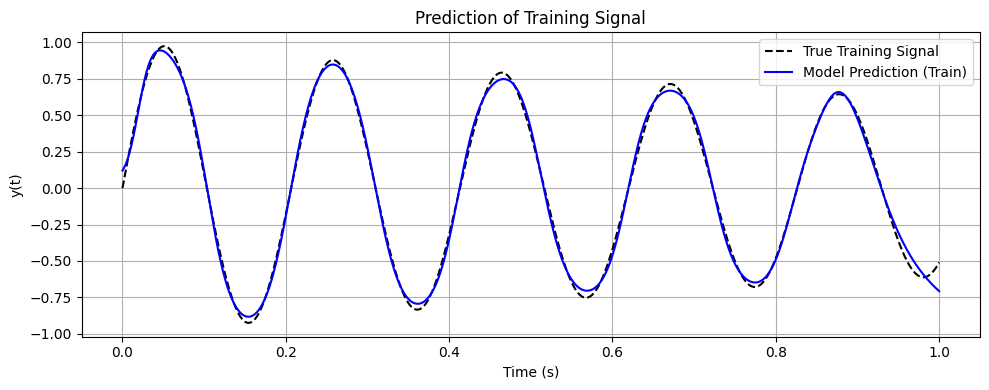

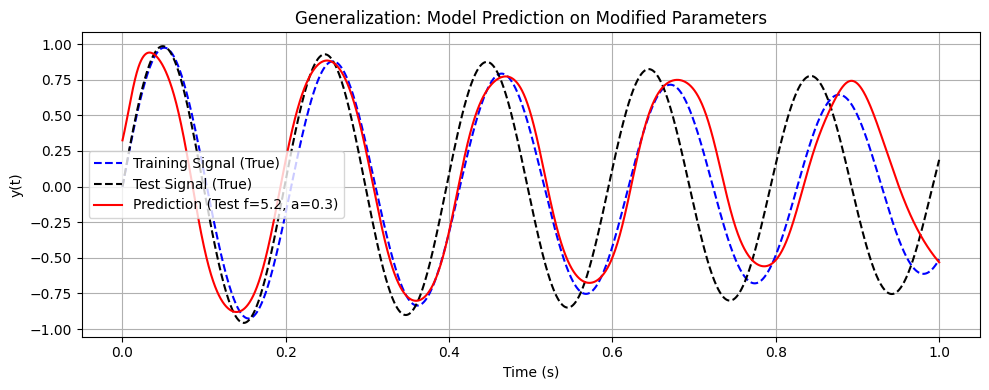

In [ ]:
# FFNN Model with (t, f, a) as Input Features for Generalization

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Set seed
torch.manual_seed(42)

# Training parameters
A0 = 1.0
f_train = 5.0
a_train = 0.5
b_train = 1.0
omega0_train = 2 * torch.pi * f_train

# Time
t_full = torch.unsqueeze(torch.linspace(0, 1, 3600), dim=1)

# True output
y_full = A0 * torch.exp(-a_train * t_full) * torch.sin(omega0_train * t_full - b_train * t_full)

# Input features: [t, f, a]
t_norm = t_full - 0.5
f_full = torch.full_like(t_full, f_train)
a_full = torch.full_like(t_full, a_train)
X_full = torch.cat([t_norm, f_full, a_full], dim=1)

# Train/val split
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    X_full.numpy(), y_full.numpy(), test_size=0.2, random_state=42)

X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32)
X_val = torch.tensor(X_val_np, dtype=torch.float32)
y_val = torch.tensor(y_val_np, dtype=torch.float32)

# Model: input is 3D [t, f, a]
model = nn.Sequential(
    nn.Linear(3, 128),
    nn.Tanh(),
    nn.Linear(128, 128),
    nn.Tanh(),
    nn.Linear(128, 1)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.MSELoss()

train_loss, val_loss = [], []

# Training loop
for epoch in range(4000):
    model.train()
    pred_train = model(X_train)
    loss = loss_fn(pred_train, y_train)
    train_loss.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        pred_val = model(X_val)
        val_loss.append(loss_fn(pred_val, y_val).item())

# Save model
torch.save(model.state_dict(), "/content/ffnn_param_input.pth")

# Plot loss
plt.figure(figsize=(10, 3))
plt.semilogy(train_loss, label="Train Loss", color="blue")
plt.semilogy(val_loss, label="Validation Loss", color="orange")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss (log scale)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Predict on training signal
with torch.no_grad():
    y_pred_train_full = model(X_full)

plt.figure(figsize=(10, 4))
plt.plot(t_full.numpy(), y_full.numpy(), label="True Training Signal", linestyle="--", color="black")
plt.plot(t_full.numpy(), y_pred_train_full.numpy(), label="Model Prediction (Train)", color="blue")
plt.title("Prediction of Training Signal")
plt.xlabel("Time (s)")
plt.ylabel("y(t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Predict with new (f_test, a_test)
f_test = 5.2
a_test = 0.3
f_vec = torch.full_like(t_full, f_test)
a_vec = torch.full_like(t_full, a_test)
X_test = torch.cat([t_norm, f_vec, a_vec], dim=1)
y_test = A0 * torch.exp(-a_test * t_full) * torch.sin(2 * torch.pi * f_test * t_full - b_train * t_full)

with torch.no_grad():
    y_pred_test = model(X_test)

# Compare
plt.figure(figsize=(10, 4))
plt.plot(t_full.numpy(), y_full.numpy(), label="Training Signal (True)", linestyle="--", color="blue")
plt.plot(t_full.numpy(), y_test.numpy(), label="Test Signal (True)", linestyle="--", color="black")
plt.plot(t_full.numpy(), y_pred_test.numpy(), label="Prediction (Test f=5.2, a=0.3)", color="red")
plt.title("Generalization: Model Prediction on Modified Parameters")
plt.xlabel("Time (s)")
plt.ylabel("y(t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
